# AUUC勉強
[参考リンク](https://qiita.com/0NE_shoT_/items/7b91474430c1f190c470)

## セッティング
- ECサイトにおけるMA訴求（セールがやっている旨を知らせるメール）の効果を計測し、アップリフトモデリングを行いたいとする
- MA訴求はABテスト形式にて行われるものとする
    - Treatment: MA訴求が行われる
    - Contorl  : MA訴求が行われない
- 訴求により特定のセグメントは購入率が上昇し、特定のセグメントは購入率が減少するものとする
- どのモデルに従うのが良いのか判断する指標としてAUUCがどのように機能するのかの確認を行う

## モジュールインポート

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.metrics import auc
from tqdm import tqdm

## 関数定義

In [159]:
def generate_data(random_seed: int, data_size: int):
    '''アップリフトモデリング対象となるデータを作成する
       └施策の訴求方法の工夫: 訴求方法を2種類用意し、どちらの方法で訴求されるかはユーザーごとにランダムで割り当てる
        ├Treatment(T=1): MA訴求が行われる
        └Contorl  (T=0): MA訴求が行われない
    Args:
        random_seed (int): 乱数のシード値
        data_size   (int): データの行数

    Returns:
        df: 効果検証対象となるデータフレーム
            ├X1     : 特徴量1（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├X2     : 特徴量2（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├X3     : 特徴量3（サイト回遊意欲・購入意欲の高さとは関係ない交絡因子でないもの）
            ├T      : MA訴求対象（Treatmentは1、Controlは0）
            ├y0_prob: Controlの時の購入確率
            ├y1_prob: Treatmentの時の購入確率
            ├y_prob : 購入確率
            └Y      : 購入有無
    '''

    np.random.seed(random_seed)
    size = data_size
    
    # サイト回遊意欲・購入意欲の高さ: X0・X1・X2が存在し、X0は未観測とする
    X0 = np.random.uniform(0, 5, size=size)
    X1 = np.random.uniform(0, 5, size=size)
    X2 = np.random.uniform(0, 5, size=size)
    # サイト回遊意欲・購入意欲の高さとは関係ない観測可能な特徴量X3を設定する
    X3 = np.random.uniform(0, 5, size=size)
    
    # MA訴求: ランダムで訴求2パターンが割り当てられるものとする（Treatmentは1、Controlは0）
    T = np.array([])
    for i in range(size):
        T_i = np.random.choice(2, size=1, p=[0.5, 0.5])[0]
        T = np.append(T, T_i)  
        
    # 購入の有無: サイト回遊意欲・購入意欲が高いほど、購入確率も高く、またMA訴求により購入確率が上がるものとする
    # ただし、X1が高いほどMA訴求の効果は高く、X2が高いほどMA訴求の効果は低いものとする
    y_prob_t0 = (X0 + X1 + X2) / 30 + np.random.uniform(-0.01, 0.01, size=size)
    y_prob_t1 = (X0 + X1 + X2) / 30 + np.random.uniform(-0.01, 0.01, size=size) + 0.1*T + X1/30 - X2/30
    y_prob_t0 = np.clip(y_prob_t0, 0, 1)
    y_prob_t1 = np.clip(y_prob_t1, 0, 1)
    y0_prob = y_prob_t0
    y1_prob = y_prob_t1
    y_prob = T * y_prob_t1 + (1-T) * y_prob_t0
    Y = np.array([])
    for i in range(size):
        Y_i = np.random.choice(2, size=1, p=[1-y_prob[i], y_prob[i]])[0]
        Y = np.append(Y, Y_i)
    
    df = pd.DataFrame({'X1':X1, 'X2':X2, 'X3':X3, 'T':T, 'y0_prob': y0_prob, 'y1_prob': y1_prob, 'y_prob': y_prob, 'Y': Y}).astype('float')
    return df

In [160]:
def return_bad_pred_uplift_score(df: pd.DataFrame):
    '''アップリフトモデリング対象となるデータからアップリフトスコア予測値を算出する
       └精度の低いモデルを想定
    Args:
        df (pd.DataFrame): アップリフトモデリング対象となるデータフレーム

    Returns:
        pred_uplift_score: アップリフト予測値
    '''
    pred_uplift_score = df['X3'] / 10

    return pred_uplift_score

In [161]:
def return_good_pred_uplift_score(df: pd.DataFrame):
    '''アップリフトモデリング対象となるデータからアップリフトスコア予測値を算出する
       └精度が比較的高いモデルを想定
    Args:
        df (pd.DataFrame): アップリフトモデリング対象となるデータフレーム

    Returns:
        pred_uplift_score: アップリフト予測値
    '''
    pred_uplift_score = df['y1_prob'] - df['y0_prob'] + np.random.uniform(-0.1, 0.1, size=data_size)

    return pred_uplift_score

In [174]:
def return_auuc(df: pd.DataFrame, uplift_score_column_name: str):
    '''アップリフトモデリング済みデータからAUUCを算出する
    Args:
        df                       (pd.DataFrame): アップリフトモデリング対象となるデータフレーム
        uplift_score_column_name (str)         : アップリフトスコアが格納されている列名

    Returns:
        auuc: AUUC
    '''
    df = df.sort_values(by=uplift_score_column_name, ascending=False)

    # 累積指標の計算
    df['cumulative_Tr'] = df['T'].cumsum()
    df['cumulative_Cr'] = (~df['T'].astype(bool)).cumsum()
    df['cumulative_Tr_Y'] = (df['Y'] * df['T']).cumsum()
    df['cumulative_Cr_Y'] = (df['Y'] * (1 - df['T'])).cumsum()
    
    # 累積コンバージョン率の計算
    df['Tr_rate'] = np.where(df['cumulative_Tr'] > 0, df['cumulative_Tr_Y'] / df['cumulative_Tr'], 0)
    df['Cr_rate'] = np.where(df['cumulative_Cr'] > 0, df['cumulative_Cr_Y'] / df['cumulative_Cr'], 0)

    # Uplift（リフト）の計算
    df['uplift'] = df['Tr_rate'] - df['Cr_rate']
    
    # 横軸: 割合 (サンプルの割合)
    df['percentage'] = np.arange(1, len(df) + 1) / len(df)
    
    # AUUCの計算（曲線下の面積）
    auuc = auc(df['percentage'], df['uplift'])

    return auuc

## AUUCの計算詳細を理解する

In [176]:
# デモデータを取得する
i = 42
data_size = 20
df = generate_data(random_seed=i, data_size=data_size)
df['good_pred_uplift_score'] = return_good_pred_uplift_score(df)
display(df)

,X1,X2,X3,T,y0_prob,y1_prob,y_prob,Y,good_pred_uplift_score
0,3.059264,0.610191,1.943386,1.0,0.175367,0.372523,0.372523,1.0,0.170713
1,0.697469,2.475885,1.356745,1.0,0.266959,0.312872,0.312872,0.0,0.072374
2,1.460723,0.171943,4.143688,0.0,0.172708,0.215741,0.172708,0.0,0.069738
3,1.831809,4.546602,1.783767,0.0,0.312562,0.214098,0.312562,0.0,-0.091309
4,2.280350,1.293900,1.404673,0.0,0.153296,0.172585,0.153296,0.0,-0.062653
5,3.925880,3.312611,2.713480,0.0,0.262268,0.286267,0.262268,0.0,0.091059
6,0.998369,1.558555,0.704621,1.0,0.093119,0.182599,0.182599,0.0,0.053636
7,2.571172,2.600340,4.010985,1.0,0.321857,0.422989,0.422989,0.0,0.038435
8,2.962073,2.733551,0.372753,1.0,0.284616,0.387796,0.387796,0.0,0.011335
9,0.232252,0.924272,4.934435,0.0,0.148103,0.133711,0.148103,0.0,0.003787


## 良いモデルと悪いモデルでAUUCに差が出るのかシミュレーションを行う

In [163]:
data_size = 10000
n_trials = 10

bad_auuc_list = []
good_auuc_list = []
for i in tqdm(range(n_trials)):
    df = generate_data(random_seed=i, data_size=data_size)
    df['bad_pred_uplift_score'] = return_bad_pred_uplift_score(df)
    bad_auuc = return_auuc(df=df, uplift_score_column_name='bad_pred_uplift_score')
    # print(f'悪いモデルでのAUUC: {bad_auuc: ,.3f}')
    bad_auuc_list.append(bad_auuc)
    
    df['good_pred_uplift_score'] = return_good_pred_uplift_score(df)
    good_auuc = return_auuc(df=df, uplift_score_column_name='good_pred_uplift_score')
    # print(f'良いモデルでのAUUC: {good_auuc: ,.3f}')
    good_auuc_list.append(good_auuc)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.91it/s]


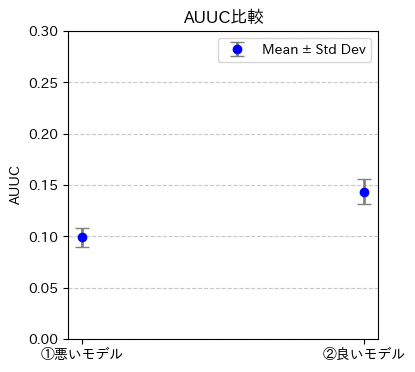

In [172]:
# 凡例を設定
categories = ['①悪いモデル', '②良いモデル']

# 各モデルのAUUCの平均・標準偏差を取得する
avg_list = []
avg_bad_auuc = np.array(bad_auuc_list).mean()
avg_list.append(avg_bad_auuc)
avg_good_auuc = np.array(good_auuc_list).mean()
avg_list.append(avg_good_auuc)

std_list = []
std_bad_auuc = np.array(bad_auuc_list).std()
std_list.append(std_bad_auuc)
std_good_auuc = np.array(good_auuc_list).std()
std_list.append(std_good_auuc)

# 比較結果を描画
plt.figure(figsize=(4, 4))
# 点とエラーバーを描画
plt.errorbar(
    categories,
    avg_list,
    yerr=std_list,
    fmt='o',  # 点のマーカー
    color='blue',  # 点の色
    ecolor='gray',  # エラーバーの色
    elinewidth=2,  # エラーバーの線幅
    capsize=5,  # エラーバーの端の長さ
    label='Mean ± Std Dev'
)
plt.title('AUUC比較')
plt.ylabel('AUUC')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.ylim(0, 0.3)
plt.show()